# 02 — Fundamentals of ML and Linear Regression (Hands-on)

Course: **Machine Learning and Artificial Intelligence for Astronomy**  
Dataset: **NASA Exoplanet Archive export** (`nea_2026_jan.csv`)

**Goal**
- Understand regression workflow (features/target → train/test → fit → evaluate)
- Demonstrate **gradient descent** on linear regression
- See why **feature scaling / log transforms** matter for optimization
- Fit baseline models with **scikit-learn** in both **linear** and **log–log** space

We will use:
- Feature: **planet mass**
- Target: **planet radius**


## 0. Setup


In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

plt.rcParams["figure.dpi"] = 120
sns.set_context("notebook")


## 1. Load the dataset

In [119]:
DATA_PATHS = [
    Path("../data/nea_2026_jan.csv"),
    Path("nea_2026_jan.csv"),
]

data_path = next((p for p in DATA_PATHS if p.exists()), None)
if data_path is None:
    raise FileNotFoundError(
        "Could not find nea_2026_jan.csv. Tried:\n"
        + "\n".join([str(p) for p in DATA_PATHS])
        + "\n\nEdit DATA_PATHS to match your repository structure."
    )

df = pd.read_csv(data_path)
print(f"Loaded: {data_path}  |  shape={df.shape}")
df.head()


Loaded: ..\data\nea_2026_jan.csv  |  shape=(6065, 14)


,pl_name,hostname,default_flag,sy_snum,sy_pnum,discoverymethod,disc_year,pl_orbper,pl_orbsmax,pl_rade,pl_bmasse,pl_eqt,st_teff,st_met
0,11 Com b,11 Com,1,2,1,Radial Velocity,2007,323.21000,1.178,NaN,4914.898486,NaN,4874.0,-0.26
1,11 UMi b,11 UMi,1,1,1,Radial Velocity,2009,516.21997,1.530,NaN,4684.814200,NaN,4213.0,-0.02
2,14 And b,14 And,1,1,1,Radial Velocity,2008,186.76000,0.775,NaN,1131.151301,NaN,4888.0,-0.21
3,14 Her b,14 Her,1,1,2,Radial Velocity,2002,1765.03890,2.774,NaN,2559.472162,NaN,NaN,NaN
4,16 Cyg B b,16 Cyg B,1,3,1,Radial Velocity,1996,798.50000,1.660,NaN,565.737400,NaN,5750.0,0.06


## 2. Select feature and target columns

The NASA Exoplanet Archive export can have different column names. We try common candidates.


In [120]:
MASS_COL_CANDIDATES = ["pl_bmasse"]
RAD_COL_CANDIDATES  = ["pl_rade"]

def pick_first_existing(cands, columns):
    return next((c for c in cands if c in columns), None)

MASS_COL = pick_first_existing(MASS_COL_CANDIDATES, df.columns)
RAD_COL  = pick_first_existing(RAD_COL_CANDIDATES,  df.columns)

MASS_COL, RAD_COL


('pl_bmasse', 'pl_rade')

## 3. Build the regression dataset (mass → radius)

We keep only rows with both mass and radius, and require positive values (needed for log10 later).


In [121]:
data = df[[MASS_COL, RAD_COL]].dropna().copy()
data = data[(data[MASS_COL] > 0) & (data[RAD_COL] > 0)]

x = data[MASS_COL].to_numpy(dtype=float)   # shape (m,)
y = data[RAD_COL].to_numpy(dtype=float)    # shape (m,)

m = len(data)
print(f"Usable rows (mass & radius): {m}")


Usable rows (mass & radius): 1452


Quick look at the mass–radius scatter (linear scale).


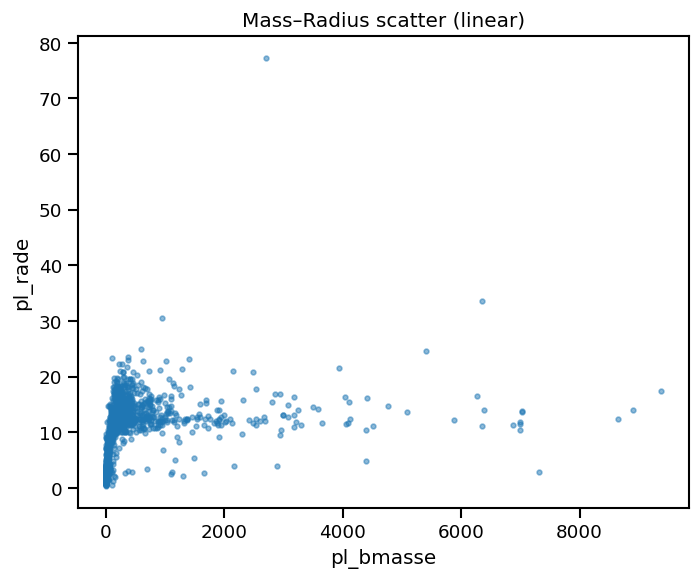

In [122]:
plt.figure(figsize=(6,5))
plt.scatter(x, y, s=8, alpha=0.5)
plt.xlabel(MASS_COL)
plt.ylabel(RAD_COL)
plt.title("Mass–Radius scatter (linear)")
plt.tight_layout()


## 4. Gradient Descent (GD) for univariate linear regression

Model:
\[ \hat{y} = w x + b \]

Cost function:
\[ J(w,b) = \frac{1}{2m} \sum_{i=1}^{m} (\hat{y}^{(i)} - y^{(i)})^2 \]

The factor 1/2 makes derivatives cleaner; it does **not** change the optimum.


In [123]:
def compute_cost(x, y, w, b):
    """J(w,b) = (1/(2m)) * sum( (w*x + b - y)^2 )"""
    m = x.shape[0]
    f = w * x + b
    return (1/(2*m)) * np.sum((f - y)**2)

def compute_gradient(x, y, w, b):
    """Returns dJ/dw, dJ/db for J(w,b) above."""
    m = x.shape[0]
    f = w * x + b
    err = f - y
    dj_dw = (1/m) * np.sum(err * x)
    dj_db = (1/m) * np.sum(err)
    return dj_dw, dj_db

def gradient_descent(x, y, w0=0.0, b0=0.0, alpha=1e-3, num_iters=1000, stop_if_diverge=True):
    """Batch gradient descent for univariate linear regression."""
    w, b = w0, b0
    J_history = []

    for i in range(num_iters):
        dj_dw, dj_db = compute_gradient(x, y, w, b)
        w = w - alpha * dj_dw
        b = b - alpha * dj_db

        J = compute_cost(x, y, w, b)
        J_history.append(J)

        if stop_if_diverge and (not np.isfinite(J) or (i > 5 and J > 1e6 * J_history[0])):
            print(f"Stopped early at iter {i+1} (cost diverging). Last cost={J}")
            break

    return w, b, J_history


### 4.0 Prepare train/test split for GD (to match scikit-learn)

To be consistent with the scikit-learn section, we run gradient descent **only on the training set** and evaluate on the test set.


In [124]:
# Train/test split once (shared by GD and scikit-learn below)
X = x.reshape(-1, 1)   # (m, 1)
y_vec = y              # (m,)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_vec, test_size=0.2, random_state=42
)

# For GD we use 1D arrays
x_train = X_train[:, 0].astype(float)
x_test  = X_test[:, 0].astype(float)


### 4.1 GD on **raw** mass and radius (training set)

We start from **w=0, b=0** and compare **three learning rates** automatically.
**w=0, b=0** and large learning rate (*large for unscaled data*) usually leads Cost function to diverge

Expectation:
- large α → divergence/instability
- small α → slow but stable convergence


In [125]:
def run_gd_and_predict(x_train, y_train, x_test, y_test, w0, b0, alpha, num_iters):
    w, b, J_hist = gradient_descent(x_train, y_train, w0=w0, b0=b0, alpha=alpha, num_iters=num_iters)
    yhat_train = w * x_train + b
    yhat_test  = w * x_test  + b
    mse_train = mean_squared_error(y_train, yhat_train)
    mse_test  = mean_squared_error(y_test,  yhat_test)
    return w, b, J_hist, mse_train, mse_test


alpha=1e-07 | w=0.0050552, b=0.000133307 | MSE train=81.4, test=92.8 | last J=40.7


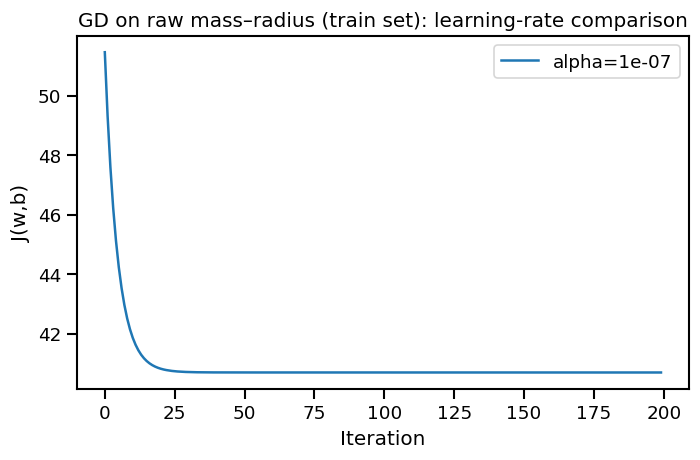

In [126]:
alphas_raw = [1e-7]   
iters = 200
w0, b0 = 0.0, 0.0

results_raw = {}
for a in alphas_raw:
    w, b, J_hist, mse_tr, mse_te = run_gd_and_predict(x_train, y_train, x_test, y_test, w0, b0, a, iters)
    results_raw[a] = (w, b, J_hist, mse_tr, mse_te)
    print(f"alpha={a:g} | w={w:.6g}, b={b:.6g} | MSE train={mse_tr:.3g}, test={mse_te:.3g} | last J={J_hist[-1]:.3g}")


plt.figure(figsize=(6,4))
for a, (_, _, J_hist, _, _) in results_raw.items():
    plt.plot(J_hist, label=f"alpha={a:g}")
plt.xlabel("Iteration")
plt.ylabel("J(w,b)")
plt.title("GD on raw mass–radius (train set): learning-rate comparison")
plt.legend()
plt.tight_layout()

### 4.2 GD on **log–log** transformed data (training set)

Now we fit in log space, using the same train/test split.


In [127]:
xlog_train = np.log10(x_train)
ylog_train = np.log10(y_train)

xlog_test  = np.log10(x_test)
ylog_test  = np.log10(y_test)


alpha=0.3 | w=0.375634, b=0.0972933 | mse(log) train=0.0413, test=0.0419 | last J=0.0206
alpha=0.2 | w=0.372628, b=0.103928 | mse(log) train=0.0413, test=0.0419 | last J=0.0206


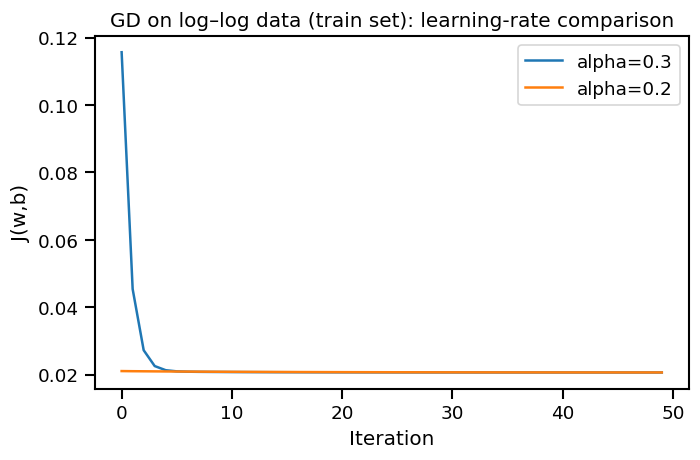

In [128]:
alphas_log = [0.3, 0.2,]   # 0.2 may overshoot depending on the dataset
iters_log = 50
w0, b0 = 0.0, 0.0

results_log = {}
for a in alphas_log:
    w, b, J_hist, mse_tr, mse_te = run_gd_and_predict(xlog_train, ylog_train, xlog_test, ylog_test, w0, b0, a, iters_log)
    results_log[a] = (w, b, J_hist, mse_tr, mse_te)
    print(f"alpha={a:g} | w={w:.6g}, b={b:.6g} | mse(log) train={mse_tr:.3g}, test={mse_te:.3g} | last J={J_hist[-1]:.3g}")


plt.figure(figsize=(6,4))
for a, (_, _, J_hist, _, _) in results_log.items():
    plt.plot(J_hist, label=f"alpha={a:g}")
plt.xlabel("Iteration")
plt.ylabel("J(w,b)")
plt.title("GD on log–log data (train set): learning-rate comparison")
plt.legend()
plt.tight_layout()

### Pick a GD solution (log–log) to compare later

We'll use this learning rate for the parameter comparison with scikit-learn.


In [129]:
alpha_pick = 0.3
w_gd_log, b_gd_log, *_ = results_log[alpha_pick]
print("Picked GD (log–log) w, b:", w_gd_log, b_gd_log)

Picked GD (log–log) w, b: 0.37563443990084233 0.0972932959605406


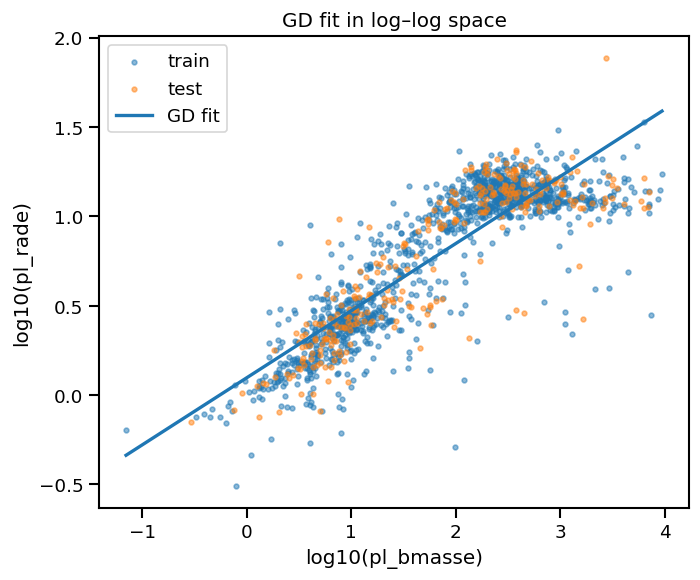

In [130]:
plt.figure(figsize=(6,5))
plt.scatter(xlog_train, ylog_train, s=8, alpha=0.5, label="train")
plt.scatter(xlog_test, ylog_test, s=8, alpha=0.5, label="test")

xg = np.linspace(xlog_train.min(), xlog_train.max(), 200)
yg = w_gd_log * xg + b_gd_log
plt.plot(xg, yg, linewidth=2, label="GD fit")

plt.xlabel(f"log10({MASS_COL})")
plt.ylabel(f"log10({RAD_COL})")
plt.title("GD fit in log–log space")
plt.legend()
plt.tight_layout()


## 5. scikit-learn regression (baseline)

Now we fit linear regression with scikit-learn in:
1) linear space (radius vs mass)  
2) log–log space (log10 radius vs log10 mass)

We do a **train/test split** to evaluate generalization.


### 5.1 Linear space: train/test split + fit


In [131]:
X = x.reshape(-1, 1)   # shape (m, 1)
y_vec = y              # shape (m,)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_vec, test_size=0.2, random_state=42
)

lin = LinearRegression()
lin.fit(X_train, y_train)

yhat_test = lin.predict(X_test)

mse = mean_squared_error(y_test, yhat_test)
r2 = r2_score(y_test, yhat_test)

print("sklearn (linear) w, b:", lin.coef_[0], lin.intercept_)
print("Test mse:", mse)
print("Test R2:", r2)


sklearn (linear) w, b: 0.0021282205777970625 7.735307185518051
Test mse: 46.3183257343183
Test R2: 0.12411023639025975


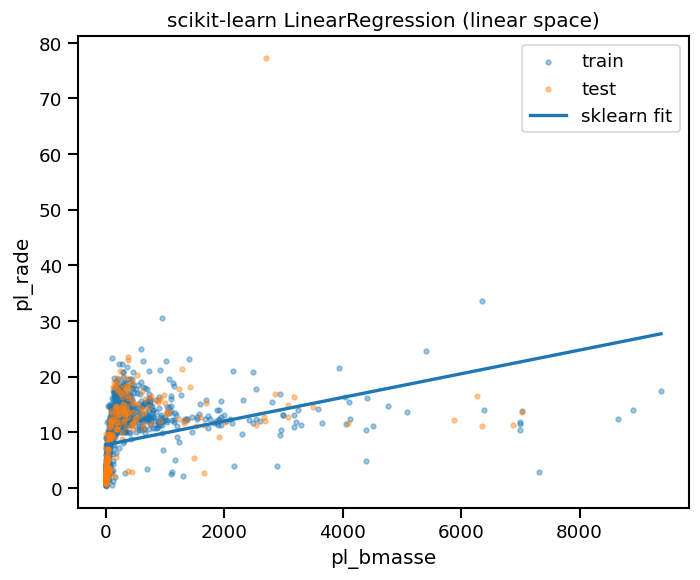

In [132]:
plt.figure(figsize=(6,5))
plt.scatter(X_train[:,0], y_train, s=8, alpha=0.4, label="train")
plt.scatter(X_test[:,0],  y_test,  s=8, alpha=0.4, label="test")

x_grid = np.linspace(X[:,0].min(), X[:,0].max(), 200).reshape(-1,1)
plt.plot(x_grid[:,0], lin.predict(x_grid), linewidth=2, label="sklearn fit")

plt.xlabel(MASS_COL)
plt.ylabel(RAD_COL)
plt.title("scikit-learn LinearRegression (linear space)")
plt.legend()
plt.tight_layout()


### 5.2 Log–log space: train/test split + fit


In [133]:
xlog = np.log10(x_train)
ylog = np.log10(y_train)

Xlog = xlog.reshape(-1, 1)  # shape (m, 1)
ylog_vec = ylog             # shape (m,)

Xlog_train, Xlog_test, ylog_train, ylog_test = train_test_split(
    Xlog, ylog_vec, test_size=0.2, random_state=42
)

lin_log = LinearRegression()
lin_log.fit(Xlog_train, ylog_train)

ylog_hat_test = lin_log.predict(Xlog_test)

mse_log = mean_squared_error(ylog_test, ylog_hat_test)
r2_log = r2_score(ylog_test, ylog_hat_test)

print("sklearn (log-log) w, b:", lin_log.coef_[0], lin_log.intercept_)
print("Test mse (log):", mse_log)
print("Test R2 (log):", r2_log)


sklearn (log-log) w, b: 0.38324228579054925 0.08267362233045739
Test mse (log): 0.041082710865163956
Test R2 (log): 0.7139050694076388


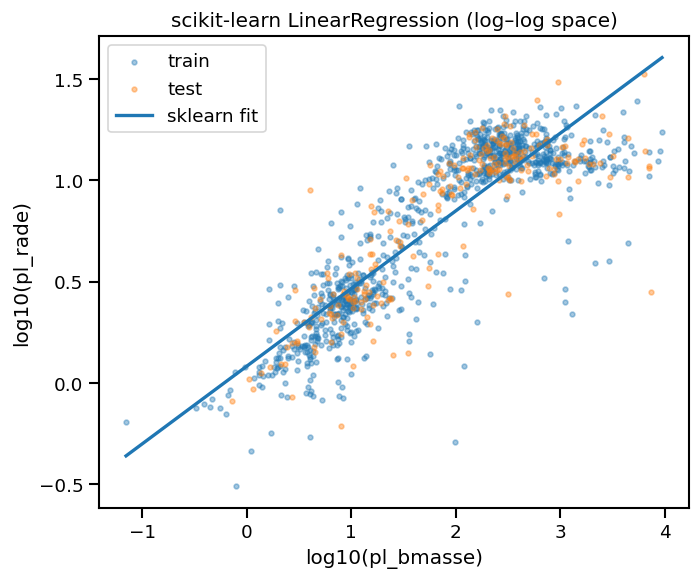

In [134]:
plt.figure(figsize=(6,5))
plt.scatter(Xlog_train[:,0], ylog_train, s=8, alpha=0.4, label="train")
plt.scatter(Xlog_test[:,0],  ylog_test,  s=8, alpha=0.4, label="test")

xg2 = np.linspace(Xlog[:,0].min(), Xlog[:,0].max(), 200).reshape(-1,1)
plt.plot(xg2[:,0], lin_log.predict(xg2), linewidth=2, label="sklearn fit")

plt.xlabel(f"log10({MASS_COL})")
plt.ylabel(f"log10({RAD_COL})")
plt.title("scikit-learn LinearRegression (log–log space)")
plt.legend()
plt.tight_layout()


## 6. Compare GD vs scikit-learn (log–log)

GD was run on the full dataset (no split) as an optimization demo.
scikit-learn uses a closed-form solver and we evaluated on a train/test split.
Slopes/intercepts should be broadly consistent.


In [135]:
print("GD (log–log)       w, b:", w_gd_log, b_gd_log)
print("sklearn (log–log)  w, b:", lin_log.coef_[0], lin_log.intercept_)


GD (log–log)       w, b: 0.37563443990084233 0.0972932959605406
sklearn (log–log)  w, b: 0.38324228579054925 0.08267362233045739


## 7. Reflection questions

1. Why did GD struggle in linear space on raw mass and radius?  
2. Why did log–log help?  
3. What does the learning rate control?  
4. What patterns do you expect in residuals (hint: multiple regimes in mass–radius)?  
5. Next class: what kind of model could capture non-linear regimes better than a straight line?


## 8 Feature scaling for the **linear** mass–radius GD

In the *linear* (non-log) relation, Mass spans a wide range.  
Gradient Descent can become inefficient or unstable when the feature is not scaled.

Below we repeat GD with **standardized mass** (using training-set mean and std), keeping the **same learning rate** to highlight the difference.


In [136]:
# Standardize mass using the TRAINING set statistics
mu_x = np.mean(x_train)
sigma_x = np.std(x_train)

x_train_s = (x_train - mu_x) / sigma_x
x_test_s  = (x_test  - mu_x) / sigma_x

print(f"Training mass mean = {mu_x:.3g}, std = {sigma_x:.3g}")


Training mass mean = 398, std = 945


[Raw]    alpha=1e-06 | w=0.0050552, b=0.000133307 | MSE train=81.4, test=92.8 | last J=40.7
Stopped early at iter 7 (cost diverging). Last cost=4.499843643576352e+75
[Raw]    alpha=0.2 | w=9.24773e+34, b=3.49933e+31 | MSE train=9e+75, test=1.06e+76 | last J=4.5e+75
[Scaled] alpha=1e-06 | w=4.02399e-05, b=0.000171654 | MSE train=108, test=126 | last J=54.1
        Recovered original units: w=4.2564e-08, b=0.000154705
[Scaled] alpha=0.2 | w=1.98882, b=8.48382 | MSE train=30.6, test=46.3 | last J=15.3
        Recovered original units: w=0.00210368, b=7.64613


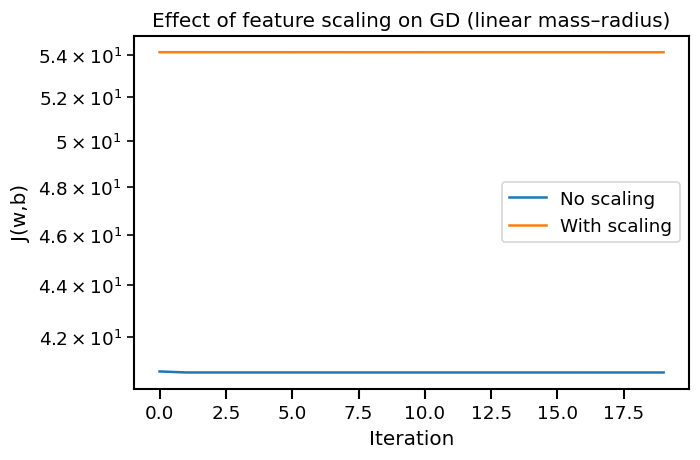

In [138]:
# ONE place to control GD hyperparams
alphas = [1e-6, 0.2]     # change here
iters  = 20         # change here

# Run GD on RAW feature(s)
results_raw = {}
for a in alphas:
    w_r, b_r, J_hist_r, mse_tr_r, mse_te_r = run_gd_and_predict(
        x_train, y_train, x_test, y_test,
        w0=w0, b0=b0, alpha=a, num_iters=iters
    )
    results_raw[a] = (w_r, b_r, J_hist_r, mse_tr_r, mse_te_r)
    print(f"[Raw]    alpha={a:g} | w={w_r:.6g}, b={b_r:.6g} | "
          f"MSE train={mse_tr_r:.3g}, test={mse_te_r:.3g} | last J={J_hist_r[-1]:.3g}")

# Run GD on SCALED feature(s) with the SAME alpha + iters
results_scaled = {}
for a in alphas:
    w_s, b_s, J_hist_s, mse_tr_s, mse_te_s = run_gd_and_predict(
        x_train_s, y_train, x_test_s, y_test,
        w0=w0, b0=b0, alpha=a, num_iters=iters
    )
    results_scaled[a] = (w_s, b_s, J_hist_s, mse_tr_s, mse_te_s)
    print(f"[Scaled] alpha={a:g} | w={w_s:.6g}, b={b_s:.6g} | "
          f"MSE train={mse_tr_s:.3g}, test={mse_te_s:.3g} | last J={J_hist_s[-1]:.3g}")

    # Convert (w_s, b_s) back to original mass units:
    # y = w_s * ((x - mu)/sigma) + b_s  = (w_s/sigma)*x + (b_s - w_s*mu/sigma)
    w_phys = w_s / sigma_x
    b_phys = b_s - w_s * mu_x / sigma_x
    print(f"        Recovered original units: w={w_phys:.6g}, b={b_phys:.6g}")

# Compare convergence (cost history) for the first alpha
a0 = alphas[0]
J_hist_raw = results_raw[a0][2]
J_hist_s   = results_scaled[a0][2]

plt.figure(figsize=(6,4))
plt.plot(J_hist_raw, label="No scaling")
plt.plot(J_hist_s, label="With scaling")
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("J(w,b)")
plt.title("Effect of feature scaling on GD (linear mass–radius)")
plt.legend()
plt.tight_layout()
plt.show()
